In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [14]:
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

In [15]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
val = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Some instance of MNIST

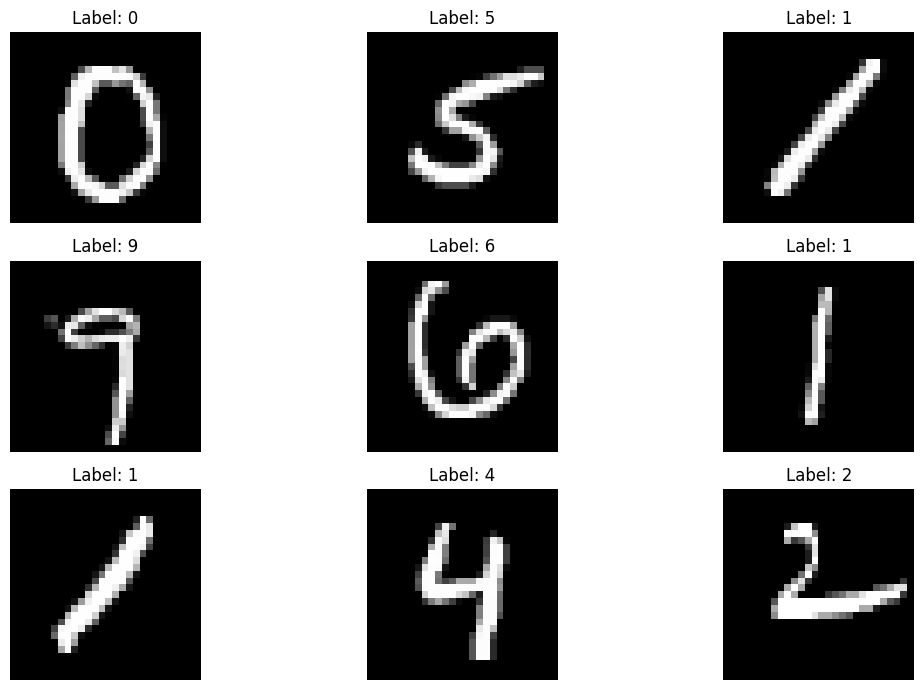

In [16]:
images, labels = next(iter(train))

plt.figure(figsize=(12, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Linear Model

In [17]:
class MNISTLinear(nn.Module) :
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(28 * 28, 128)
        self.FC2 = nn.Linear(128, 64)
        self.FC3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.FC1(x))
        x = F.relu(self.FC2(x))
        return F.log_softmax(self.FC3(x), dim=1)

### CNN Model

In [18]:
class MNISTClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return F.log_softmax(x, dim=1)

### Training

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LinearModel = MNISTLinear().to(device)
loss_fn_Linear = nn.CrossEntropyLoss()
optimizer_Linear = optim.AdamW(LinearModel.parameters())

CNNmodel = MNISTClassification().to(device)
loss_fn_CNN = nn.CrossEntropyLoss()
optimizer_CNN = optim.AdamW(CNNmodel.parameters())

In [20]:
def train_model(model, loss_fn, optimizer) :
    for epoch in range(10) :
        model.train()
        train_loss = 0

        loop = tqdm(train, desc=f"Epoch {epoch+1}/{10} [Training]", leave=False)
        for images, labels in loop :
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        model.eval()
        val_loss = 0
        f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
        accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

        with torch.no_grad() :
            val_loop = tqdm(val, desc=f"Epoch {epoch+1}/{10} [Validation]", leave=False)
            for images, labels in val_loop :
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_loop.set_postfix(loss=loss.item())

                f1.update(preds, labels)
                accuracy.update(preds, labels)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
            f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    



In [21]:
train_model(LinearModel, loss_fn_Linear, optimizer_Linear)

Epoch 1 | Train Loss: 0.4249 | Val Loss: 0.2622 | Val F1: 0.9218 | Val Acc: 0.9221


Epoch 2 | Train Loss: 0.2074 | Val Loss: 0.1768 | Val F1: 0.9461 | Val Acc: 0.9461


Epoch 3 | Train Loss: 0.1551 | Val Loss: 0.1594 | Val F1: 0.9501 | Val Acc: 0.9506


Epoch 4 | Train Loss: 0.1229 | Val Loss: 0.1283 | Val F1: 0.9634 | Val Acc: 0.9632


Epoch 5 | Train Loss: 0.1022 | Val Loss: 0.1197 | Val F1: 0.9640 | Val Acc: 0.9638


Epoch 6 | Train Loss: 0.0898 | Val Loss: 0.1134 | Val F1: 0.9668 | Val Acc: 0.9672


Epoch 7 | Train Loss: 0.0788 | Val Loss: 0.1173 | Val F1: 0.9659 | Val Acc: 0.9658


Epoch 8 | Train Loss: 0.0700 | Val Loss: 0.1135 | Val F1: 0.9647 | Val Acc: 0.9644


Epoch 9 | Train Loss: 0.0616 | Val Loss: 0.1297 | Val F1: 0.9606 | Val Acc: 0.9603


Epoch 10 | Train Loss: 0.0568 | Val Loss: 0.1078 | Val F1: 0.9676 | Val Acc: 0.9678


In [22]:
train_model(CNNmodel, loss_fn_CNN, optimizer_CNN)

Epoch 1 | Train Loss: 0.6050 | Val Loss: 0.1184 | Val F1: 0.9662 | Val Acc: 0.9662


Epoch 2 | Train Loss: 0.2635 | Val Loss: 0.0827 | Val F1: 0.9767 | Val Acc: 0.9769


Epoch 3 | Train Loss: 0.2112 | Val Loss: 0.0739 | Val F1: 0.9799 | Val Acc: 0.9800


Epoch 4 | Train Loss: 0.1875 | Val Loss: 0.0631 | Val F1: 0.9819 | Val Acc: 0.9820


Epoch 5 | Train Loss: 0.1736 | Val Loss: 0.0588 | Val F1: 0.9834 | Val Acc: 0.9834


Epoch 6 | Train Loss: 0.1627 | Val Loss: 0.0590 | Val F1: 0.9835 | Val Acc: 0.9835


Epoch 7 | Train Loss: 0.1556 | Val Loss: 0.0570 | Val F1: 0.9840 | Val Acc: 0.9840


Epoch 8 | Train Loss: 0.1442 | Val Loss: 0.0553 | Val F1: 0.9845 | Val Acc: 0.9846


Epoch 9 | Train Loss: 0.1346 | Val Loss: 0.0499 | Val F1: 0.9857 | Val Acc: 0.9857


Epoch 10 | Train Loss: 0.1383 | Val Loss: 0.0510 | Val F1: 0.9846 | Val Acc: 0.9846


### Test verification

In [23]:
def creat_heatmap(confusion_matrix) :
    plt.figure(figsize=(12, 7))
    sns.heatmap(confusion_matrix.compute().to('cpu'),
                annot=True, 
                fmt='d', 
                cmap='Blues', 
                linewidths=0.5, 
                square=True, 
                cbar_kws={"shrink": 0.75})

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

In [24]:
def test_verification(model) :
    f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
    accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
    CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

    with torch.no_grad() :
        for images, labels in test :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            f1_test.update(output, labels)
            accuracy_test.update(output, labels)
            CF.update(output, labels)

    print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")
    creat_heatmap(CF)

Test Accuracy:0.9691 | Test F1:0.9690


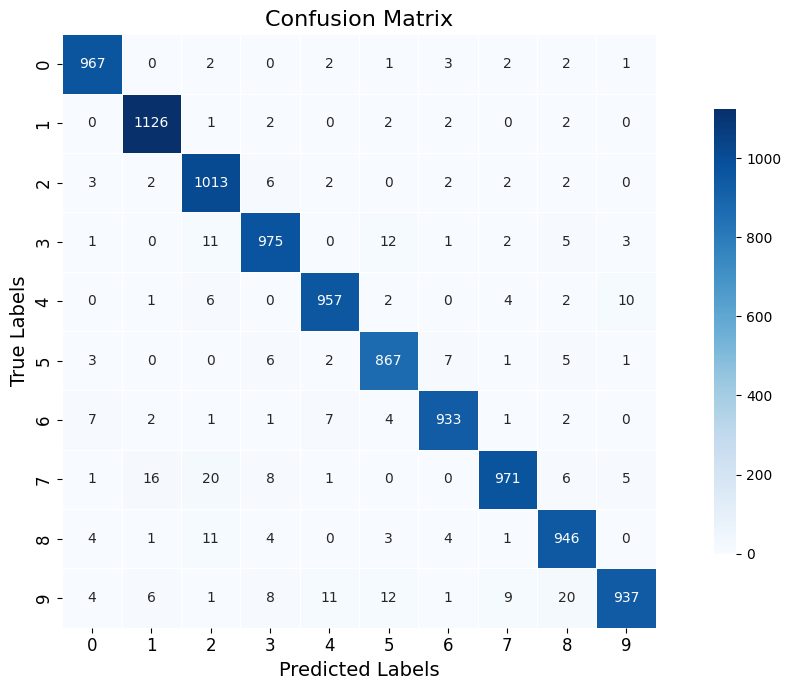

In [25]:
test_verification(LinearModel)

Test Accuracy:0.9891 | Test F1:0.9891


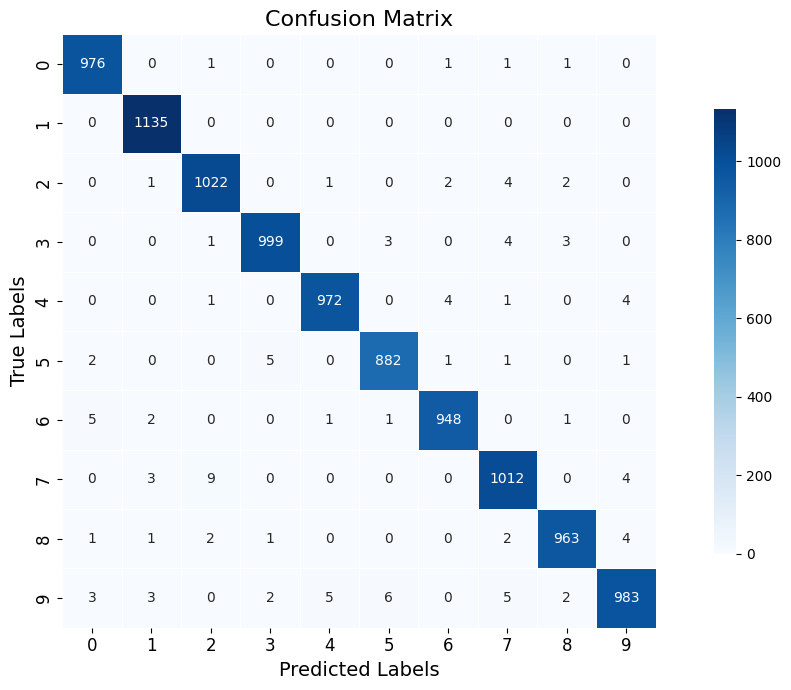

In [26]:
test_verification(CNNmodel)

# Training Results

## 📊 1. Linear Model

| Epoch | Train Loss | Val Loss | Val F1 | Val Acc |
| :---: | :--------: | :------: | :----: | :-----: |
|   1   |   0.4249   |  0.2622  | 0.9218 |  0.9221 |
|   2   |   0.2074   |  0.1768  | 0.9461 |  0.9461 |
|   3   |   0.1551   |  0.1594  | 0.9501 |  0.9506 |
|   4   |   0.1229   |  0.1283  | 0.9634 |  0.9632 |
|   5   |   0.1022   |  0.1197  | 0.9640 |  0.9638 |
|   6   |   0.0898   |  0.1134  | 0.9668 |  0.9672 |
|   7   |   0.0788   |  0.1173  | 0.9659 |  0.9658 |
|   8   |   0.0700   |  0.1135  | 0.9647 |  0.9644 |
|   9   |   0.0616   |  0.1297  | 0.9606 |  0.9603 |
|   10  |   0.0568   |  0.1078  | 0.9676 |  0.9678 |

**🎯 Test Accuracy:** `0.9691`
**🎯 Test F1 Score:** `0.9690`

---

## 🧠 2. CNN Model

| Epoch | Train Loss | Val Loss | Val F1 | Val Acc |
| :---: | :--------: | :------: | :----: | :-----: |
|   1   |   0.6050   |  0.1184  | 0.9662 |  0.9662 |
|   2   |   0.2635   |  0.0827  | 0.9767 |  0.9769 |
|   3   |   0.2112   |  0.0739  | 0.9799 |  0.9800 |
|   4   |   0.1875   |  0.0631  | 0.9819 |  0.9820 |
|   5   |   0.1736   |  0.0588  | 0.9834 |  0.9834 |
|   6   |   0.1627   |  0.0590  | 0.9835 |  0.9835 |
|   7   |   0.1556   |  0.0570  | 0.9840 |  0.9840 |
|   8   |   0.1442   |  0.0553  | 0.9845 |  0.9846 |
|   9   |   0.1346   |  0.0499  | 0.9857 |  0.9857 |
|   10  |   0.1383   |  0.0510  | 0.9846 |  0.9846 |

**🎯 Test Accuracy:** `0.9891`
**🎯 Test F1 Score:** `0.9891`

---

## 🔍 Final Comparison

| Metric        | 🧮 Linear Model | 🧠 CNN Model           |
| ------------- | --------------- | ---------------------- |
| Final Val Acc | 0.9678          | 0.9846                 |
| Final Val F1  | 0.9676          | 0.9846                 |
| Test Accuracy | 0.9691          | 0.9891                 |
| Test F1 Score | 0.9690          | 0.9891                 |
| Convergence   | Slower          | Faster                 |
| Model Size    | Smaller         | Larger                 |
| Feature Use   | Raw Pixels      | Local Spatial Patterns |

---

## ✅ Summary

* The **CNN model** still significantly outperforms the **Linear model**, especially in terms of generalization on the test set.
* CNN’s convolutional layers help it extract local spatial features, making it more effective and quicker to converge.
* The **Linear model**, although less accurate, is simpler and may be suitable for fast prototyping or deployment in resource-constrained environments.


### Save Model

In [27]:
torch.save(LinearModel.state_dict(), "LinearModel_weight.pth")
torch.save(CNNmodel.state_dict(), "CNNModel_weight.pth")